# Implémentation algorithme k-NN

Dans ce projet, nous allons nous intéresser à l'implémentation de l'algorithme k-NN. 
De plus, en calculant la justesse de prédiction et le temps d'exécution de notre algorithme créé précédemment, nous allons les comparer avec ceux qu'on obtient en travaillant avec la bibliothèque sckit learn. 

In [1]:
from sklearn import datasets
import pandas as pd
import timeit
from math import sqrt, ceil
import heapq
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display

## Datasets

Nous allons voir quels sont les jeux de données avec lesquels nous avons travaillé.  Nous avons utilisé trois jeux de données différents : 2 qui sont des données standards de python et un jeu de données réel toujours de python. 
Afin de choisir les variables avec lesquelles nous allons travailler, nous cherchons quelles sont les variables les plus significatives ; c'est-à-dire qu'elles sont les variables avec une forte corrélation. 

### Iris Dataset (Toy Dataset)

Ce jeu de données contient 4 colonnes donnant la largeur et longueur des pétales et sépales de différentes iris. 

In [2]:
iris = datasets.load_iris()
iris_corr = pd.DataFrame(iris.data, columns=iris.feature_names)
print("La corrélation entre les variables du jeu de donnée Iris:")
iris_corr.corr().style.format("{:.3}").background_gradient(cmap=plt.get_cmap('coolwarm'))


La corrélation entre les variables du jeu de donnée Iris:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.0,-0.118,0.872,0.818
sepal width (cm),-0.118,1.0,-0.428,-0.366
petal length (cm),0.872,-0.428,1.0,0.963
petal width (cm),0.818,-0.366,0.963,1.0


Grâce au tableau, nous remarquons une très forte corrélation entre les deux dernières colonnes: ces variables concernent les dimensions des pétales.

Nous allons donc travailler sur ces deux colonnes : 
- **Petal length** : Longueur de la pétale 
- **Petal width** : Largeur de la pétale 

De plus, les données que nous souhaitons prédire sont le type d'iris:  
- **Setosa**
- **Versicolor** 
- **Virginica**

In [3]:
iris_data = iris.data[:, [2, 3]].tolist()
iris_target = iris.target

df_iris = pd.DataFrame(iris_data)
df_iris.describe()

,0,1
count,150.000000,150.000000
mean,3.758000,1.199333
std,1.765298,0.762238
min,1.000000,0.100000
25%,1.600000,0.300000
50%,4.350000,1.300000
75%,5.100000,1.800000
max,6.900000,2.500000


### Wine Dataset (Toy Dataset)

Ce jeu de données contient 13 colonnes pour les 13 analyses différentes faite sur différents vins provenant d'un même secteur en Italie. 

In [4]:
wine = datasets.load_wine()
wine_corr = pd.DataFrame(wine.data, columns=wine.feature_names)
print("La corrélation entre les variables du jeu de donnée Wine:")
wine_corr.corr().style.format("{:.3}").background_gradient(cmap=plt.get_cmap('coolwarm'))

La corrélation entre les variables du jeu de donnée Wine:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,1.0,0.0944,0.212,-0.31,0.271,0.289,0.237,-0.156,0.137,0.546,-0.0717,0.0723,0.644
malic_acid,0.0944,1.0,0.164,0.289,-0.0546,-0.335,-0.411,0.293,-0.221,0.249,-0.561,-0.369,-0.192
ash,0.212,0.164,1.0,0.443,0.287,0.129,0.115,0.186,0.00965,0.259,-0.0747,0.00391,0.224
alcalinity_of_ash,-0.31,0.289,0.443,1.0,-0.0833,-0.321,-0.351,0.362,-0.197,0.0187,-0.274,-0.277,-0.441
magnesium,0.271,-0.0546,0.287,-0.0833,1.0,0.214,0.196,-0.256,0.236,0.2,0.0554,0.066,0.393
total_phenols,0.289,-0.335,0.129,-0.321,0.214,1.0,0.865,-0.45,0.612,-0.0551,0.434,0.7,0.498
flavanoids,0.237,-0.411,0.115,-0.351,0.196,0.865,1.0,-0.538,0.653,-0.172,0.543,0.787,0.494
nonflavanoid_phenols,-0.156,0.293,0.186,0.362,-0.256,-0.45,-0.538,1.0,-0.366,0.139,-0.263,-0.503,-0.311
proanthocyanins,0.137,-0.221,0.00965,-0.197,0.236,0.612,0.653,-0.366,1.0,-0.0252,0.296,0.519,0.33
color_intensity,0.546,0.249,0.259,0.0187,0.2,-0.0551,-0.172,0.139,-0.0252,1.0,-0.522,-0.429,0.316


Ici, nous constatons une forte corrélation entre la colonne 'total_phenols' et 'flavanoids: ces deux variables représentent des composés phénoliques. 

Ainsi, nous allons travailler sur ces deux colonnes : 
- **Flavonoïde** : Pigmentation responsable de la coloration du vin 
- **Total_phenols** : Groupe de composés chimiques qui affectent la couleur

De plus, les données que nous souhaitons prédire sont les classes du vin: 
- **Class 1**
- **Class 2**
- **Class 3** 

In [5]:
wine_data = wine.data[:, [5,6]].tolist()
wine_target = wine.target
wine_data_len = len(wine_data)

df_wine = pd.DataFrame(wine_data)
df_wine.describe()

,0,1
count,178.000000,178.000000
mean,2.295112,2.029270
std,0.625851,0.998859
min,0.980000,0.340000
25%,1.742500,1.205000
50%,2.355000,2.135000
75%,2.800000,2.875000
max,3.880000,5.080000


### Forest Covertypes Dataset (Real World Dataset)

Ce dernier jeu de données concerne les couvertures forestières, c’est-à-dire les superficies des terres couvertes par la forêt, aux Etats-Unis. Il contient 13 variables dont 3 qui sont développées en plusieurs colonnes c’est pour cela qu’il y a plus de 13 colonnes. 

In [6]:
forest = datasets.fetch_covtype()
forest_corr = pd.DataFrame(forest.data)
print("La corrélation entre les variables du jeu de donnée Forest Covertypes:")
forest_corr.corr().style.format("{:.3}").background_gradient(cmap=plt.get_cmap('coolwarm'))

La corrélation entre les variables du jeu de donnée Forest Covertypes:


Dans ce dernier tableau, nous remarquons une forte corrélation entre la colonne 3 et 4 représentant respectivement la distance horizontale et verticale de la couverture forestière avec la plateforme où il y a de l'eau la plus proche. 

Nous allons donc travailler sur ces deux colonnes : 
- **Horizontal_Distance_To_Hydrology**: La distance en horizontal entre la plateforme où y a les arbres et la plateforme où y a de l'eau
- **Vertical_Distance_To_Hydrology**: La distance en vertical entre la plateforme où y a les arbres et la plateforme où y a de l'eau

De plus, les données que nous souhaitons prédire sont les types couvertures forestière: 
- **1: Spruce/Fir**
- **2: Lodgepole Pine**
- **3: Ponderosa Pine**
- **4: Cottonwood/Willow**
- **5: Aspen**
- **6: Douglas-fir**
- **7: Krummholz**

Cependant, ce jeu de données contient plus de 10 000 lignes, de ce fait, nous avons choisi de travailler sur 0.2% des données. 

In [7]:
x, forest_data, y, forest_target = train_test_split(forest.data, forest.target, test_size=0.002, random_state=0, stratify=forest.target)
forest_data = forest_data[:, [3, 4]].tolist()
forest_data_len = len(forest_data)
df_forest = pd.DataFrame(forest_data)
df_forest.describe()

,0,1
count,1163.000000,1163.000000
mean,277.371453,47.368014
std,222.138239,60.182557
min,0.000000,-103.000000
25%,95.000000,7.000000
50%,228.000000,30.000000
75%,400.000000,73.500000
max,1201.000000,377.000000


## k-NN Projet vs k-NN Scikit

Ici, nous allons comparer plusieurs algorithmes en fonction de leur justesse de prédiction ainsi que de leur vitesse d'éxecution. 
Voici les algortihmes que nous allons comparer: 
- **knn kdtree projet** : notre algorithme donné dans le livrable 2
- **knn kdtree sklearn** : 
    - algortihme kdtree
    - algortihme automatique 

### Knn Kd-tree Projet

#### Construction de l'arbre

In [8]:
def gen_kd_tree(data: list, col_index=0):
    next_col_index = 1 if col_index == 0 else 0
    if len(data) > 1:
        data.sort(key=lambda z: z[col_index])
        median_index = len(data) >> 1

        median_point = data[median_index]
        
        #split array at median point
        leaf_right = data[median_index + 1:]
        leaf_left = data[:median_index]
        
        return [
            median_point,
            gen_kd_tree(leaf_left, next_col_index),
            gen_kd_tree(leaf_right, next_col_index),
        ]
    elif len(data) == 1:
        return [data[0], None, None]

In [9]:
def find_knn(kd_tree, target_point, k, nearest_neighbors=None, z=0):
    next_z = 1 if z == 0 else 0

    # si nearest neighors vide -> is root TRUE
    is_root = not nearest_neighbors

    #si root TRUE -> créé une liste vide
    if is_root:
        nearest_neighbors = []
    #si kd_tree n'est pas nul
    if kd_tree:
        #calcul de la distance euclidienne et de la distance entre les x ou les y
        node = kd_tree[0]
        dist_e = distance(node, target_point)
        dist_xy = abs(node[z] - target_point[z])

        if len(nearest_neighbors) < k:
            #si nearest_neighbors toujours pas rempli 
            #-> continuer de rajouter les points dans la liste
            heapq.heappush(nearest_neighbors, (-dist_e, node))
        elif dist_e < -nearest_neighbors[0][0]:
            #si nearest_neighbors rempli 
            #-> comparer distance euclidienne des nouveaux points avec le point dans la liste qui a la plus grande distance euclidienne
            heapq.heappushpop(nearest_neighbors, (-dist_e, node))

        leaf_togo = [1, 2]
        if dist_xy > -nearest_neighbors[0][0]:
            #si distance entre les x ou les y est plus grande que la distance euclidiennede X et node 
            #-> aller uniquement à gauche sinon aller à gauche et droite
            del leaf_togo[1]
        
        #effectuer cette fonction sur les feuilles qui suivent 
        for i in leaf_togo:
            find_knn(kd_tree[i], target_point, k, nearest_neighbors, next_z)
    
    #une fois fini -> remettre dans l'ordre 
    if is_root:
        nearest_neighbors = [[h[1], -h[0]] for h in nearest_neighbors]
        return nearest_neighbors

#### Justesse de prédiction

In [10]:
def distance(a, b):
    distance_euclidean = sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
    return distance_euclidean

In [11]:
def projet_knn_kdtree(x_train, x_test, y_train, y_test, nb_neighbors):
    y_predict = []
    kd_tree = gen_kd_tree(x_train.copy())
    for target in x_test:
        knn = find_knn(kd_tree, target, k=nb_neighbors)
        result = Counter([y_train[x_train.index(i[0])] for i in knn]).most_common(1)[0][0]
        y_predict.append(result)
    return y_predict

In [12]:
def calculate_accuracy(y_pred, y_test):
    score_knn = 0

    for i, value in enumerate(y_test):
        if y_pred[i] == value:
            score_knn += 1

    return score_knn / len(y_test)

### Knn Sklearn

#### Algorithme : arbre de décision

In [13]:
def sklearn_knn_kdtree(x_train, x_test, y_train, y_test, nb_neighbors):
    knn_kdtree = KNeighborsClassifier(n_neighbors=nb_neighbors, algorithm='kd_tree', leaf_size=2, metric='euclidean')
    knn_kdtree.fit(x_train, y_train)
    return knn_kdtree


#### Algorithme : automatique 

In [14]:
def sklearn_knn_auto(x_train, x_test, y_train, y_test, nb_neighbors):
    knn_kdtree = KNeighborsClassifier(n_neighbors=nb_neighbors)
    knn_kdtree.fit(x_train, y_train)
    return knn_kdtree

## Performance

In [15]:
all_datasets = {
                "Iris dataset": [iris_data, iris_target],
                "Wine dataset": [wine_data, wine_target],
                "Forest dataset": [forest_data, forest_target]}


Iris dataset


,k,Taux k-NN Projet (%),Taux k-NN Scikit kdtree (%),Taux k-NN Scikit auto (%),Temps k-NN Projet (ms),Temps k-NN Scikit kdtree (ms),Temps k-NN Scikit auto (ms)
0,1,100.000000,100.000000,100.000000,0.006300,0.002651,0.001354
1,7,100.000000,100.000000,100.000000,0.016566,0.001682,0.001351
2,13,100.000000,100.000000,100.000000,0.017565,0.001569,0.001822
3,19,100.000000,100.000000,100.000000,0.018852,0.001605,0.001420
4,25,100.000000,100.000000,100.000000,0.019961,0.001537,0.001252
5,31,100.000000,100.000000,100.000000,0.020998,0.001534,0.001244
6,37,100.000000,100.000000,100.000000,0.022349,0.001573,0.001907
7,43,100.000000,100.000000,100.000000,0.023979,0.002314,0.001348
8,49,100.000000,100.000000,100.000000,0.025527,0.001735,0.001247
9,55,100.000000,100.000000,100.000000,0.027803,0.001561,0.001292


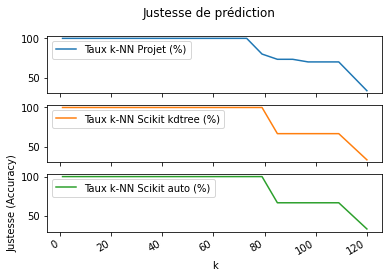

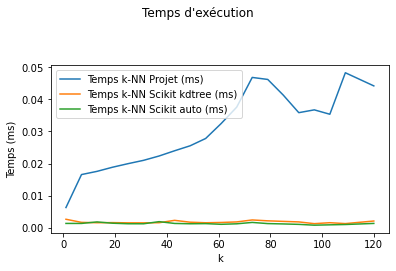

Wine dataset


,k,Taux k-NN Projet (%),Taux k-NN Scikit kdtree (%),Taux k-NN Scikit auto (%),Temps k-NN Projet (ms),Temps k-NN Scikit kdtree (ms),Temps k-NN Scikit auto (ms)
0,1,63.888889,75.000000,75.000000,0.009273,0.001833,0.001482
1,8,77.777778,80.555556,80.555556,0.023440,0.001783,0.001437
2,15,86.111111,86.111111,86.111111,0.029106,0.001728,0.001376
3,22,80.555556,86.111111,86.111111,0.028039,0.002312,0.001480
4,29,80.555556,80.555556,80.555556,0.029765,0.001680,0.001367
5,36,83.333333,86.111111,86.111111,0.033514,0.001802,0.001351
6,43,80.555556,80.555556,80.555556,0.036676,0.001741,0.001418
7,50,83.333333,83.333333,83.333333,0.044462,0.002246,0.001427
8,57,77.777778,77.777778,77.777778,0.039175,0.001744,0.001606
9,64,80.555556,80.555556,80.555556,0.040763,0.001689,0.001412


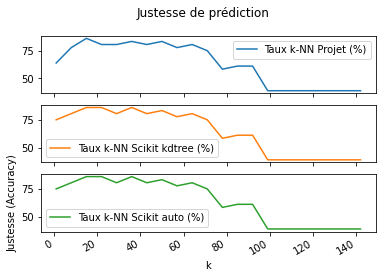

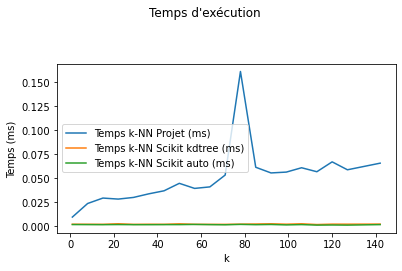

In [ ]:
for dataset_name, data in all_datasets.items():
    x_train, x_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.2, random_state=0, stratify=data[1])
    
    sklearn_exec_time = []
    sklearn_auto_exec_time = []
    projet_exec_time = []
    
    sklearn_score = []
    sklearn_auto_score = []
    projet_score = []
    
    if len(x_train) % 20 == 0:
        k_list = list(range(1, len(x_train), int(len(x_train) / 20)))
    else: 
        reste = len(x_train) % 20
        k_list = list(range(1, len(x_train) - reste, int(len(x_train) / 20)))
    k_list[-1] = len(x_train) #valeur maximale de k 
            
    for k in k_list:
        # sklearn : kdtree
        start_time_sklearn = timeit.default_timer()
        sklearn_result = sklearn_knn_kdtree(x_train, x_test, y_train, y_test, nb_neighbors=k)
        time_execution_sklearn = (timeit.default_timer() - start_time_sklearn)
        #print("knn kdtree sklearn avec k = "+str(k)+": --- %s seconds ---" % (time_execution_sklearn))
        
        score_sklearn = sklearn_result.score(x_test, y_test) * 100

        sklearn_exec_time.append(time_execution_sklearn)
        sklearn_score.append(score_sklearn)
        
        
        
        # sklearn : auto
        start_time_sklearn_auto = timeit.default_timer()
        sklearn_auto_result = sklearn_knn_auto(x_train, x_test, y_train, y_test, nb_neighbors=k)
        time_execution_sklearn_auto = (timeit.default_timer() - start_time_sklearn_auto)
        #print("knn auto sklearn avec k = "+str(k)+": --- %s seconds ---" % (time_execution_sklearn_auto))
        
        score_sklearn_auto = sklearn_auto_result.score(x_test, y_test) * 100

        sklearn_auto_exec_time.append(time_execution_sklearn_auto)
        sklearn_auto_score.append(score_sklearn_auto)       
        
        
        #projet
        start_time_projet = timeit.default_timer()
        projet_result = projet_knn_kdtree(x_train, x_test, y_train, y_test, nb_neighbors=k)
        time_execution_projet = (timeit.default_timer() - start_time_projet)
        #print("knn kdtree projet avec k = "+str(k)+": --- %s seconds ---" % (time_execution_projet))
        
        score_project = calculate_accuracy(projet_result, y_test) * 100

        projet_exec_time.append(time_execution_projet)
        projet_score.append(score_project)
    
    
    df = pd.DataFrame({'k': k_list,
                       'Taux k-NN Projet (%)': projet_score,
                       'Taux k-NN Scikit kdtree (%)': sklearn_score,
                       'Taux k-NN Scikit auto (%)': sklearn_auto_score,
                       'Temps k-NN Projet (ms)': projet_exec_time,
                       'Temps k-NN Scikit kdtree (ms)': sklearn_exec_time,
                       'Temps k-NN Scikit auto (ms)': sklearn_auto_exec_time
                       
                      })
    print(dataset_name)
    display(df)

        #Justess
    df.plot.line(x="k", y=['Taux k-NN Projet (%)','Taux k-NN Scikit kdtree (%)','Taux k-NN Scikit auto (%)'], subplots=True) #subplots =graphiques séparés par série
    plt.suptitle('Justesse de prédiction')
    plt.xlabel('k')
    plt.ylabel('Justesse (Accuracy)')
#   plt.tight_layout(pad=2.5) # This module provides routines to adjust subplot params so that subplots are nicely fit in the figure.
    plt.show()

    #Temps d'execution  
    df.plot.line(x="k", y=['Temps k-NN Projet (ms)', 'Temps k-NN Scikit kdtree (ms)', 'Temps k-NN Scikit auto (ms)'], subplots=False)
    plt.suptitle("Temps d'exécution")
    plt.xlabel('k')
    plt.ylabel('Temps (ms)')
    plt.tight_layout(pad=2.5)
    plt.show()

En premier lieu, nous remarquons que le temps d'exécution est beaucoup moins important lorsque nous utilisons la bibliothèque Scikit Learn. Lorsque nous utilisons l'algorithme automatique comparé à l'algorithme kd tree, nous pouvons avoir des piques montrant que l'exécution prend légèrement plus de temps. 
Quant au taux de chaque jeu de données, quelle que soit la méthode, ce taux se ressemble en général. Même si le taux peut avoir un nombre différent, la tendance de la courbe reste généralement la même. 

Intéressant nous à estimer la valeur de k, en évitant le risque de sur-apprentissage et de sous-apprentissage, ainsi qu'à la justesse de prédiction. 

    - Iris :
Avec ce jeu de données, nous remarquons que le taux de nombre de prédictions correctes est maximale jusqu'à k qui vaut 76. Nous pouvons donc choisir un k allant jusqu'à 76. Cependant, nous pouvons prendre un k plus petit afin d'accélérer l'exécution du programme. 

    - Wine
Quant à ce jeu de données, nous constatons que la justesse de prédiction n'est jamais à 100%. Cependant, elle reste assez forte et lorsque k vaut 15, ce dernier maximise la justesse. De plus, le taux knn entre l'algorithme du projet et celui de la bibliothèque de python sont semblables excepté pour nos 5 premiers k. Nous pouvons tout de même conclure que k vaut 15.

    - Forest
Pour finir, avec ce jeu de données, on remarque que le nombre de prédictions correctes est très faible, quel que soit l'algorithme utilisé. De plus, la tendance des courbes représentant le taux est semblable entre les algorithmes de python et celui de notre projet dans l'ensemble. Cependant, dans notre projet, k maximise la justesse lorsqu'il vaut 40 alors qu'avec scklearn c'est lorsqu'il vaut 185. Nous ne pouvons donc pas déterminer précisément le k le plus optimal. Mais, si on se fit aux algorithmes de python, il serait préférable de prendre k = 185.